In [368]:
import pandas as pd, numpy as np
pd.set_option("max_columns", 50)

from matplotlib import pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'geopandas'

In [2]:
! ls /home/data/spring_2019/base/

baseline-calibration-smart-rw-52-20.skimsExcerpt.csv
baseline-calibration-smart-rw-55-20.skimsExcerpt.csv
baus_model_data.h5
bay_area_tertiary_strongly_edges.csv
bay_area_tertiary_strongly_nodes.csv
bayarea_walk_edges.csv
bayarea_walk_nodes.csv
buildings_v2.csv
drive_net_vars.csv
establishments_v2.csv
households_v2.csv
jobs_v2.csv
model_data.h5
MTC_craigslist_listings_7-10-18.csv
parcel_attr.csv
persons_v3.csv
run44-30.skimsExcerpt.csv
skims_110118.csv
units_v2.csv
walk_net_vars.csv
zones.csv


In [6]:
dd = "/home/data/spring_2019/base/"

In [106]:
hh = pd.read_csv("/home/data/spring_2019/base/households_v2.csv", nrows=10**6)

In [22]:
units = pd.read_csv(dd + "units_v2.csv", nrows=100000)

In [109]:
persons = pd.read_csv(dd + "persons_v3.csv", nrows=1000000)

In [48]:
persons2hh = persons.merge(hh, on="household_id", suffixes=["_p", "_hh"]).groupby(["tract", "race_id"]).agg("count")

print(persons2hh.shape)
print(len(persons2hh.index.levels[0]), "individual Census Tracts")
persons2hh.head()

(52, 33)
7 individual Census Tracts


person_id  member_id   age  primary_commute_mode  relate  \
tract  race_id                                                             
500100 1             1925       1925  1925                   990    1925   
       2               72         72    72                    47      72   
       3               97         97    97                    44      97   
       5               35         35    35                    23      35   
       6              581        581   581                   358     581   

                 edu   sex  hours  hispanic  earning  student  work_at_home  \
tract  race_id                                                                
500100 1        1843  1925   1125      1925     1499     1925          1925   
       2          69    72     55        72       61       72            72   
       3          87    97     48        97       66       97            97   
       5          35    35     23        35       35       35            35   
       6         569   581    393       581      501      581           581   

                worker  household_id  serialno  persons  building_type  cars  \
tract  race_id                                                                 
500100 1          1925          1925      1925     1925           1925  1925   
       2            72            72        72       72             72    72   
       3            97            97        97       97             97    97   
       5            35            35        35       35             35    35   
       6           581           581       581      581            581   581   

                income  race_of_head  hispanic_head  age_of_head  workers  \
tract  race_id                                                              
500100 1          1925          1925           1925         1925     1925   
       2            72            72             72           72       72   
       3            97            97             97           97       97   
       5            35            35             35           35       35   
       6           581           581            581          581      581   

                state  county  block_group  children  tenure  recent_mover  \
tract  race_id                                                               
500100 1         1925    1925         1925      1925    1925          1925   
       2           72      72           72        72      72            72   
       3           97      97           97        97      97            97   
       5           35      35           35        35      35            35   
       6          581     581          581       581     581           581   

                block_group_id  single_family  unit_id  building_id  
tract  race_id                                                       
500100 1                  1925           1925     1925         1925  
       2                    72             72       72           72  
       3                    97             97       97           97  
       5                    35             35       35           35  
       6                   581            581      581          581

In [35]:
numTracts = len(persons2hh.index.levels[0])

# Location Quotient

A location quotient provides a way to compare proportions from one smaller geography to a large, containing geography. Thus, the proportion of something needs to be calculated at both of those levels, and those two proportions need to be compared.

Need to:

1. Generate and store percentages for each reference unit.
2. Generate and store percentages for each local unit.
3. Associate reference unit with each local unit.
4. Compare.

In [344]:
def location_quotient(unit, ref_unit, variable):
    
    # Step 0 - Subset the data
    
    subset = persons[["person_id", variable, "household_id"]]\
    .merge(hh[["household_id", unit, ref_unit]], on="household_id", suffixes=["_p", "_hh"])
    
    # Step 1 - Generate and store percentages for each reference unit.
    
    ## creates a lookup table where the proportions are calculated at the county level.
    ## values can be accessed by indexing in [ref_unit, variable_i] for all i in the variable set (ie. 1 and 2 in sex)
    ref_lookup = pd.crosstab(subset[ref_unit], subset[variable]).apply(lambda r: r/r.sum(), axis=1)
    
    # -----------------------------------------------------------------------------------------------------------
    
    # Step 2 - Generate and store percentages for each local unit
    
    # this DF contains the number of people per unit being analyzed
    unit_totals = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]].groupby(level=[0,1]).agg(sum)
    
    # this DF contains the number of people for each category of the variable being analyzed
    unit_values = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]]
    
    # this DF has both the total number of persons AND the number of persons per category
    compiled = unit_values.reset_index().merge(unit_totals.reset_index(), on=[ref_unit, unit],\
                                               suffixes=["_cat", "_{}".format(unit)])\
    .groupby([ref_unit, unit, variable]).agg("sum")
    
    # create a new column with the percent of persons per that category given the unit
    compiled["pct"] = compiled["person_id_cat"] / compiled["person_id_{}".format(unit)]
    
    # -----------------------------------------------------------------------------------------------------------
    
    # Step 3 - Associate reference unit with local unit
    
    dfs = []

    for i in compiled.index.levels[0]:
        # reference geometry unit
        for j in compiled.index.levels[1]:
            # local geometry unit

            local_values = [i, j]
            cols = [ref_unit, unit]
            for k in compiled.index.levels[2]:
                # variable category
                
                # calculate location quotients by dividing proportion in unit by proportion in ref unit
                try:
                    lq = compiled.loc[i,j,k]["pct"] / ref_lookup.loc[i,k]
                
                # if there are no records for this particular variable category in this unit, LQ = 0
                except TypeError:
                    lq = 0
                    
                local_values.append(lq)
                cols.append(k)

            dfs.append(pd.DataFrame([local_values], columns=cols))
    results = pd.concat(dfs, ignore_index=True)
    
    
    #return ref_lookup, local_lookup
    return results

In [357]:
xx = location_quotient(unit="tract", ref_unit="county", variable="race_id")

In [358]:
xx.head()

,county,tract,1,2,3,5,6,7,8,9
0,85,500100,0.922725,0.854607,2.804866,1.353752,0.484428,0.600993,2.644953,1.237963
1,85,500200,1.263728,3.172144,1.783757,0.625214,0.400978,0.221182,1.472161,1.317504
2,85,500300,1.351631,3.076787,1.211782,0.298641,0.485667,0.338081,1.039825,1.187799
3,85,500400,1.810713,1.402913,1.668431,0.000000,0.125852,0.126950,1.052916,0.905627
4,85,500500,1.664630,0.472122,1.208633,0.183302,0.461905,1.556318,0.526360,1.195353


In [349]:
persons.columns

Index(['person_id', 'member_id', 'age', 'primary_commute_mode', 'relate',
       'edu', 'sex', 'hours', 'hispanic', 'earning', 'race_id', 'student',
       'work_at_home', 'worker', 'household_id'],
      dtype='object')

In [339]:
dfs = []

for i in testlittle.index.levels[0]:
    # reference geometry unit
    for j in testlittle.index.levels[1]:
        # local geometry unit
        
        local_values = [i, j]
        cols = ["county", "tract"]
        for k in testlittle.index.levels[2]:
            # variable category
            
            #test 
            try:
                lq = testlittle.loc[i,j,k]["pct"] / testbig.loc[i,k]
            except TypeError: # if there are no records from that category present
                lq = 0
            local_values.append(lq)
            cols.append(k)
        
        dfs.append(pd.DataFrame([local_values], columns=cols))
pd.concat(dfs, ignore_index=True)

,county,tract,1,2,3,5,6,7,8,9
0,85,500100,0.922725,0.854607,2.804866,1.353752,0.484428,0.600993,2.644953,1.237963
1,85,500200,1.263728,3.172144,1.783757,0.625214,0.400978,0.221182,1.472161,1.317504
2,85,500300,1.351631,3.076787,1.211782,0.298641,0.485667,0.338081,1.039825,1.187799
3,85,500400,1.810713,1.402913,1.668431,0.000000,0.125852,0.126950,1.052916,0.905627
4,85,500500,1.664630,0.472122,1.208633,0.183302,0.461905,1.556318,0.526360,1.195353
5,85,500600,1.608408,1.930743,2.250338,0.000000,0.337800,0.463630,0.874811,1.054237
6,85,500800,1.405618,1.576774,1.375337,0.348634,0.549457,0.082224,1.032034,0.920904
7,85,500901,1.014412,2.734282,0.502547,0.000000,0.900662,0.152954,1.025447,1.047489
8,85,500902,0.630456,2.630976,0.325996,0.000000,0.828177,0.000000,2.388753,1.323593
9,85,501000,1.146586,2.055335,3.340197,0.517431,0.475361,0.199692,1.724326,1.367568


<Figure size 432x288 with 0 Axes>

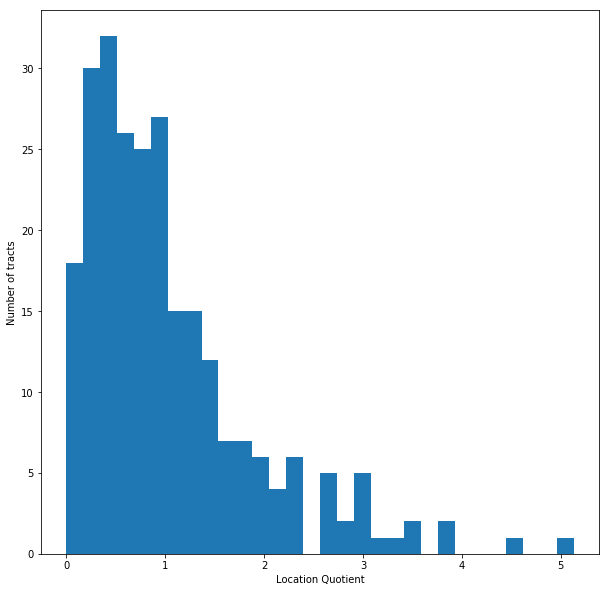

In [364]:
plt.clf()

plt.figure(figsize=(10,10))

plt.hist(xx[2], bins=30)

plt.ylabel("Number of tracts")
plt.xlabel("Location Quotient")

plt.show()